In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

In [3]:
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [4]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [5]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15

In [7]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [8]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 5.9 GB


In [9]:
# much better!
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [248]:
# Create a training file with simple derived features

rows = 50_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min','kurt','skew','time_to_failure'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'time_to_failure'] = y
    X_train.loc[segment, 'skew'] = ((x-x.mean())/x.std() ** 3).mean()
    X_train.loc[segment,'kurt'] = ((x-x.mean())/x.std() ** 4).mean()
    

100%|██████████| 12582/12582 [00:45<00:00, 274.27it/s]


In [249]:
X_train.head()

,ave,std,max,min,kurt,skew,time_to_failure
0,4.96210,6.488487003146419,104.0,-98.0,-1.709743457922741e-19,-9.592326932761353e-19,1.4563990515
1,5.06978,4.735325833730980,52.0,-56.0,4.665712260987220e-19,2.275957200481571e-18,1.4435981187
2,4.62046,3.664626773410902,30.0,-21.0,2.247091401841317e-18,8.668621376273222e-18,1.4307971859
3,4.69840,7.305159645072789,181.0,-154.0,-1.051936315832336e-19,-6.594724766273430e-19,1.4180962531
4,4.69056,6.833187168986373,152.0,-150.0,1.709743457922741e-19,1.336708521648689e-18,1.4041998259


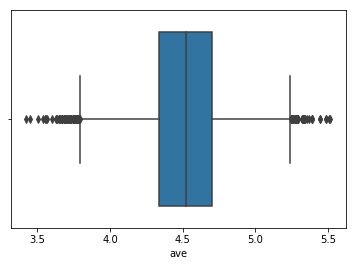

In [250]:
import seaborn as sns
sns.boxplot(x=X_train['ave'])

In [251]:
X_train['ave'].describe()

count    12582.000000000000000
mean         4.519464272770620
std          0.274993078997747
min          3.421900000000000
25%          4.339515000000000
50%          4.522460000000001
75%          4.701910000000000
max          5.515800000000000
Name: ave, dtype: float64

In [252]:
# Upper Outlier First Time
#Q1 (25%) = 4.3495
#Q3 (75%) = 4.6934
#IQR = Q3 - Q1 = 0.3439
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 4.6934 + 0.51585
#Outlier > 5.20925
# Lower Outlier
#Outlier < Q1 - (1.5* IQR)
#Outlier < 4.3495 - 0.51585
#Outlier < 3.8337

# Removing Upper Outliers
#X_train=X_train[X_train['ave']<=5.20925]
# Removing Lower Outliers
#X_train=X_train[X_train['ave']>=3.8337]

# Second Time 
# Upper Outlier
#Q1 (25%) = 4.3518
#Q3 (75%) = 4.6933
#IQR = Q3 - Q1 = 0.3415
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 4.6933 + 0.51225
#Outlier > 5.20555
# Lower Outlier
#Outlier < Q1 - (1.5* IQR)
#Outlier < 4.3518 - 0.51225
#Outlier < 3.83955

#X_train=X_train.drop([552,584,585,589,607,610,611,626,784,939])
#y_train=y_train.drop([552,584,585,589,607,610,611,626,784,939])



In [253]:
# Removing Upper Outliers
X_train=X_train[X_train['ave']<=5.20555]
# Removing Lower Outliers
X_train=X_train[X_train['ave']>=3.83955]

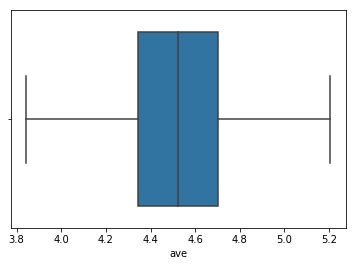

In [254]:
sns.boxplot(x=X_train['ave'])

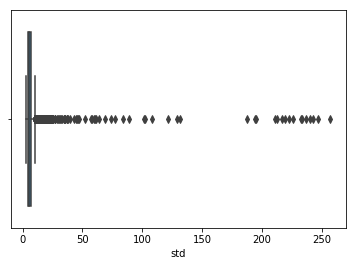

In [255]:
sns.boxplot(x=X_train['std'])

In [256]:
X_train['std'].describe()

count    12401.000000000000000
mean         6.161254957678552
std          8.853386702091816
min          2.681901109287962
25%          4.107232588690346
50%          5.240864747577445
75%          6.693291061951512
max        257.275448473620145
Name: std, dtype: float64

In [257]:
# Upper Outlier
#Q1 (25%) = 4.4741
#Q3 (75%) =6.8839
#IQR = Q3 - Q1 = 2.4098
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 6.8839 + 3.6147
#Outlier > 10.4986
#X_train=X_train[X_train['std']<=10.4986]

# Second Time
# Upper Outlier
#Q1 (25%) =  4.4370
#Q3 (75%) =6.7284
#IQR = Q3 - Q1 = 2.2914
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 6.73 + 3.4371
#Outlier > 10.1655
#X_train=X_train[X_train['std']<=10.1655]

# Third Time
# Upper Outlier
#Q1 (25%) =  4.4339
#Q3 (75%) =6.6950
#IQR = Q3 - Q1 = 2.2611
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 6.70 + 3.39165
#Outlier > 10.0867
#X_train=X_train[X_train['std']<=10.0867]

# Fourth Time
# Upper Outlier
#Q1 (25%) =  4.4331
#Q3 (75%) =6.6903
#IQR = Q3 - Q1 = 2.2572
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 6.6903 + 3.3858
#Outlier > 10.0761
#X_train=X_train[X_train['std']<=10.0761] # 10.0761

# Fifth Time
# Upper Outlier
#Q1 (25%) =  4.4330
#Q3 (75%) =6.6881
#IQR = Q3 - Q1 = 2.2551
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 6.6881 + 3.3827
#Outlier > 10.0708


In [258]:
X_train=X_train[X_train['std']<=10.0708]

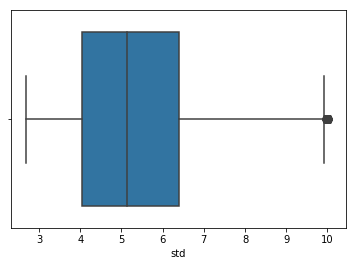

In [259]:
sns.boxplot(x=X_train['std'])

In [260]:
X_train=X_train[X_train['std']<=9.4]

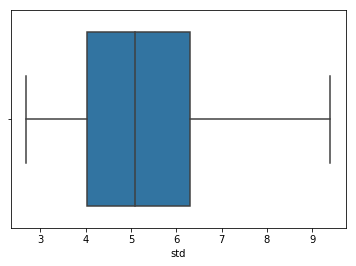

In [261]:
sns.boxplot(x=X_train['std'])

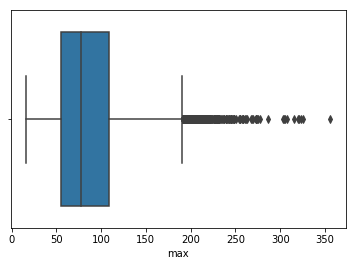

In [262]:
sns.boxplot(x=X_train['max'])

In [263]:
X_train['max'].describe()

count    11563.000000000000000
mean        86.115886880567331
std         42.218567366883001
min         16.000000000000000
25%         55.000000000000000
50%         78.000000000000000
75%        109.000000000000000
max        356.000000000000000
Name: max, dtype: float64

In [264]:
# Upper Outlier
#Q1 (25%) =  90
#Q3 (75%) =162
#IQR = Q3 - Q1 = 72
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 162 + 108
#Outlier > 270
#X_train=X_train[X_train['max']<=270]

# Second Time
# Upper Outlier
#Q1 (25%) =  90
#Q3 (75%) =156
#IQR = Q3 - Q1 = 66
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 156 + 99
#Outlier > 255
#X_train=X_train[X_train['max']<=255]

# Third Time
# Upper Outlier
#Q1 (25%) =  89
#Q3 (75%) =155
#IQR = Q3 - Q1 = 66
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 155 + 99
#Outlier > 254

In [265]:
X_train=X_train[X_train['max']<=254]

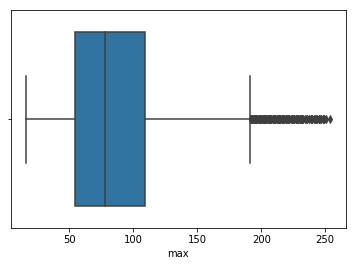

In [266]:
sns.boxplot(x=X_train['max'])

In [267]:
X_train=X_train[X_train['max']<=231]

In [310]:
X_train=X_train[X_train['max']<=185]

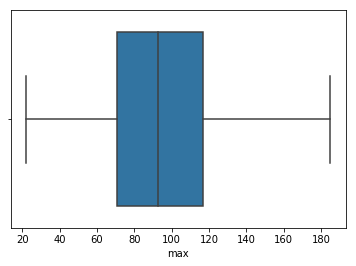

In [311]:
sns.boxplot(x=X_train['max'])

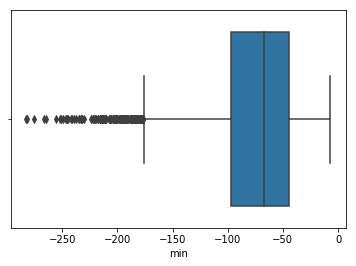

In [269]:
sns.boxplot(x=X_train['min'])

In [270]:
X_train['min'].describe()

count    11502.000000000000000
mean       -73.940879846983137
std         39.454375577636647
min       -283.000000000000000
25%        -97.000000000000000
50%        -67.000000000000000
75%        -44.000000000000000
max         -7.000000000000000
Name: min, dtype: float64

In [271]:
# Lower Outlier
#Q1 (25%) = -141
#Q3 (75%) = -77
#IQR = Q3 - Q1 = 64

#Outlier < Q1 - (1.5* IQR)
#Outlier < -141 - 96
#Outlier < -237
#X_train=X_train[X_train['min']>=-237]

# Second Time
# Lower Outlier
#Q1 (25%) = -138
#Q3 (75%) = -77
#IQR = Q3 - Q1 = 61

#Outlier < Q1 - (1.5* IQR)
#Outlier < -138 - 91.5
#Outlier < -229.5
#X_train=X_train[X_train['min']>=-229.5]

# Third Time
# Lower Outlier
#Q1 (25%) = -137
#Q3 (75%) = -76
#IQR = Q3 - Q1 = 61

#Outlier < Q1 - (1.5* IQR)
#Outlier < -137 - 91.5
#Outlier < -228.5

In [272]:
X_train=X_train[X_train['min']>=-228.5]

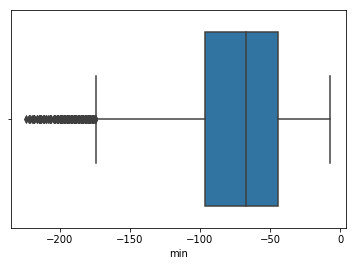

In [273]:
sns.boxplot(x=X_train['min'])

In [274]:
X_train=X_train[X_train['min']>=-211.5]

In [306]:
X_train=X_train[X_train['min']>=-175.5]

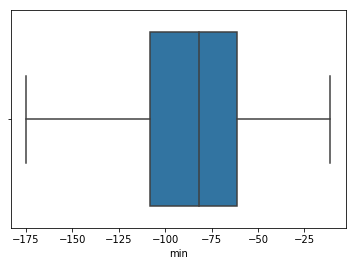

In [307]:
sns.boxplot(x=X_train['min'])

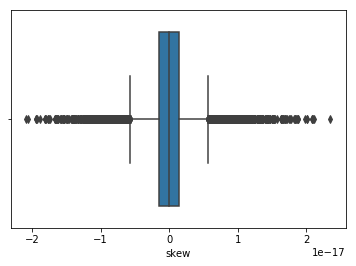

In [276]:
sns.boxplot(x=X_train['skew'])

In [277]:
X_train['skew'].describe()

count    1.145900000000000e+04
mean    -2.288674771802777e-20
std      3.820940388327863e-18
min     -2.092548356813495e-17
25%     -1.476041511239146e-18
50%     -2.220446049250313e-21
75%      1.385558334732195e-18
max      2.351896455365932e-17
Name: skew, dtype: float64

In [278]:
# Upper Outlier First Time
#Q1 (25%) = -1.3
#Q3 (75%) = 1.16
#IQR = Q3 - Q1 = 2.46
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 1.16 + 3.69
#Outlier > 4.85
# Lower Outlier
#Outlier < Q1 - (1.5* IQR)
#Outlier < -1.3 - 3.69
#Outlier < -4.99

# Removing Upper Outliers
#X_train=X_train[X_train['ave']<=5.20925]
# Removing Lower Outliers
#X_train=X_train[X_train['ave']>=3.8337]

# Second Time 
# Upper Outlier
#Q1 (25%) = 4.3518
#Q3 (75%) = 4.6933
#IQR = Q3 - Q1 = 0.3415
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 4.6933 + 0.51225
#Outlier > 5.20555
# Lower Outlier
#Outlier < Q1 - (1.5* IQR)
#Outlier < 4.3518 - 0.51225
#Outlier < 3.83955

#X_train=X_train.drop([552,584,585,589,607,610,611,626,784,939])
#y_train=y_train.drop([552,584,585,589,607,610,611,626,784,939])



In [279]:
# Removing Upper Outliers
X_train=X_train[X_train['skew']<=3.9e-18]
# Removing Lower Outliers
X_train=X_train[X_train['skew']>=-4e-18]

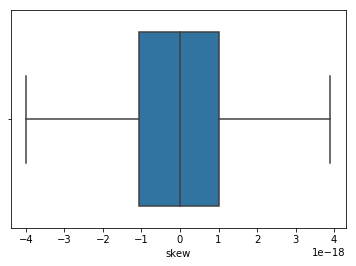

In [280]:
sns.boxplot(x=X_train['skew'])

In [281]:
# Removing Upper Outliers
X_train=X_train[X_train['skew']<=3.5e-18]
# Removing Lower Outliers
X_train=X_train[X_train['skew']>=-3.5e-18]

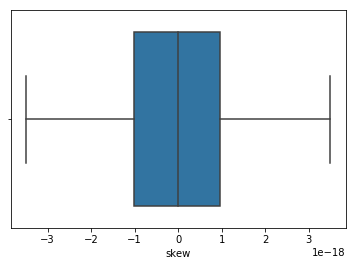

In [282]:
sns.boxplot(x=X_train['skew'])

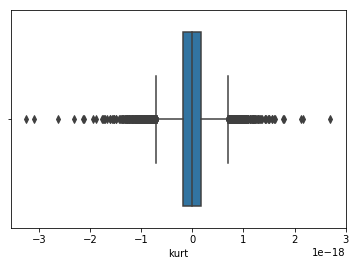

In [283]:
sns.boxplot(x=X_train['kurt'])

In [284]:
X_train['kurt'].describe()

count    8.881000000000000e+03
mean    -7.203502716161208e-21
std      3.686890200147156e-19
min     -3.259614800299460e-18
25%     -1.811051308919787e-19
50%     -2.498001805406602e-21
75%      1.704192342799615e-19
max      2.700062395888381e-18
Name: kurt, dtype: float64

In [285]:
# Upper Outlier First Time
#Q1 (25%) = -1.77
#Q3 (75%) = 1.69
#IQR = Q3 - Q1 = 3.46
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 1.69 + 4.31
#Outlier > 6
# Lower Outlier
#Outlier < Q1 - (1.5* IQR)
#Outlier < -1.77 - 3.46
#Outlier < -5.23

In [286]:
# Removing Upper Outliers
X_train=X_train[X_train['kurt']<=5.7e-19]
# Removing Lower Outliers
X_train=X_train[X_train['kurt']>=-5.23e-19]

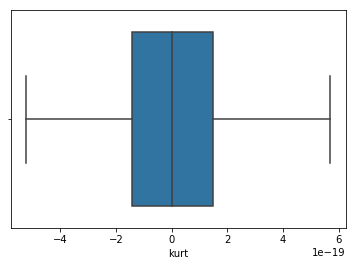

In [287]:
sns.boxplot(x=X_train['kurt'])

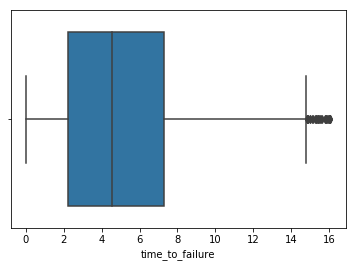

In [288]:
sns.boxplot(x=X_train['time_to_failure'])

In [289]:
X_train['time_to_failure'].describe()

count    7732.000000000000000
mean        5.017124758348265
std         3.386771021335830
min         0.000095753262030
25%         2.226773493050000
50%         4.525698487050001
75%         7.268372375399999
max        16.076598207000000
Name: time_to_failure, dtype: float64

In [290]:
# Upper Outlier First Time
#Q1 (25%) = 2.33
#Q3 (75%) = 7.38
#IQR = Q3 - Q1 = 5.05 
#Outlier > Q3 + (1.5 * IQR) 
#Outlier > 7.38 + 7.56
#Outlier > 14.94

In [291]:
# Removing Upper Outliers
X_train=X_train[X_train['time_to_failure']<=14.92]

In [304]:
# Removing Upper Outliers
X_train=X_train[X_train['time_to_failure']<=14]

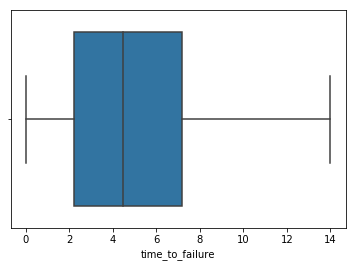

In [305]:
sns.boxplot(x=X_train['time_to_failure'])

In [312]:
X_train.shape

(7352, 7)

In [313]:
from scipy import stats

#1
pearson_coef, p_value = stats.pearsonr(X_train['ave'], X_train['time_to_failure'])
print("ave: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#2
pearson_coef, p_value = stats.pearsonr(X_train['std'], X_train['time_to_failure'])
print("std: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#3

pearson_coef, p_value = stats.pearsonr(X_train['kurt'], X_train['time_to_failure'])
print("kurt: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#4
pearson_coef, p_value = stats.pearsonr(X_train['max'], X_train['time_to_failure'])
print("max: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#5
pearson_coef, p_value = stats.pearsonr(X_train['min'], X_train['time_to_failure'])
print("min: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#6
pearson_coef, p_value = stats.pearsonr(X_train['skew'], X_train['time_to_failure'])
print("skew: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

ave: The Pearson Correlation Coefficient is -0.01203825234185786  with a P-value of P = 0.30204052695222333
std: The Pearson Correlation Coefficient is -0.3343338610498918  with a P-value of P = 1.814299191093816e-191
kurt: The Pearson Correlation Coefficient is -0.0054486905682333  with a P-value of P = 0.6404172547469379
max: The Pearson Correlation Coefficient is -0.10403373311474019  with a P-value of P = 3.787251850359757e-19
min: The Pearson Correlation Coefficient is 0.1115394482513439  with a P-value of P = 8.62818120714846e-22
skew: The Pearson Correlation Coefficient is -0.004392407749410708  with a P-value of P = 0.7065009689890849


In [314]:
x_train=X_train [['ave','max','min','std','kurt','skew']]
x_train.head()

,ave,max,min,std,kurt,skew
0,4.96210,104.0,-98.0,6.488487003146419,-1.709743457922741e-19,-9.592326932761353e-19
1,5.06978,52.0,-56.0,4.735325833730980,4.665712260987220e-19,2.275957200481571e-18
3,4.69840,181.0,-154.0,7.305159645072789,-1.051936315832336e-19,-6.594724766273430e-19
4,4.69056,152.0,-150.0,6.833187168986373,1.709743457922741e-19,1.336708521648689e-18
5,4.78834,111.0,-115.0,5.493015569284325,2.137179322403426e-19,1.509903313490213e-18


In [315]:
x_train.shape

(7352, 6)

In [316]:
y_train=X_train[['time_to_failure']]

In [317]:
y_train.head()

,time_to_failure
0,1.4563990515
1,1.4435981187
3,1.4180962531
4,1.4041998259
5,1.3914988931


In [318]:
y_train.shape

(7352, 1)

In [319]:
scaler = StandardScaler()
scaler.fit(x_train)
X_train_scaled = scaler.transform(x_train)

In [320]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

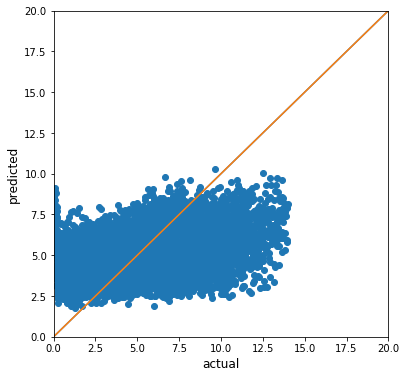

In [321]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [322]:
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 2.302


In [323]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')

In [324]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [325]:
X_train=X_train.drop(['time_to_failure'], axis=1)

In [326]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [327]:
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'kurt'] = ((x-x.mean())/x.std() ** 4).mean()
    X_test.loc[seg_id, 'skew'] = ((x-x.mean())/x.std() ** 3).mean()

In [328]:
X_test.shape

(2624, 6)

In [329]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('submission.csv')